# PCA Statistical Arbitrage

(This notebook can be found on GitHub: https://github.com/rodler/quantinsti_statarb)

### Dr Tom Starke 

*Homepage: www.aaaquants.com *

*Email: tom@aaaquants.com *

*Linkedin: Dr Tom Starke *

### What we will learn:
- Building a PCA manually
- Modelling vol curves
- Building a stock index
- Conduct a pairs-trading backtest using PCA
- Sector statistical arbitrage using PCA

In [1]:
pip install yfinance

     |████████████████████████████████| 6.3 MB 20.2 MB/s 
  Created wheel for yfinance: filename=yfinance-0.1.63-py2.py3-none-any.whl size=23918 sha256=cbf8f5ff3d401f6f74c527af0e838667478561b82e9d9b65f023d5377ab32180
  Stored in directory: /root/.cache/pip/wheels/fe/87/8b/7ec24486e001d3926537f5f7801f57a74d181be25b11157983
Successfully built yfinance
  Attempting uninstall: lxml
    Found existing installation: lxml 4.2.6
    Uninstalling lxml-4.2.6:
      Successfully uninstalled lxml-4.2.6


In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats as stats
from sklearn.linear_model import LinearRegression
from sklearn.decomposition import PCA
import scipy
import statsmodels.api as sm
import pandas as pd
from statsmodels.tsa.stattools import coint, grangercausalitytests
import matplotlib
from itertools import groupby, count
import pickle
import yfinance as yf
from dateutil.parser import parse
import datetime
from scipy.optimize import brentq 
import traceback
from google.colab import files
%matplotlib inline

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


## Build PCA from Scratch

#### First, we create a random seed for consistency

In [3]:
np.random.seed(20)

#### Create a random time series

We make it look like a price series, which starts at 100 dollars.

In [4]:
x = np.cumsum(np.random.randn(200)) + 100

#### Produce a second series with the same behaviour but higher standard deviation.

In [5]:
y = x*2 + np.random.randn(200) - 100

#### Plot both series

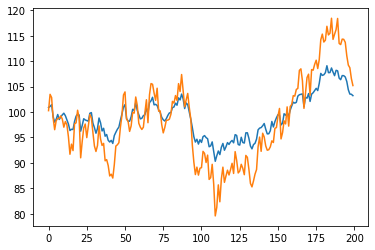

In [6]:
plt.plot(x)
plt.plot(y)

#### Fist PCA step: De-Meaning of series

In [7]:
x_ = x-np.mean(x)
y_ = y-np.mean(y)

#### Collect de-meaned series in an array

In [8]:
R = np.array([x_,y_])

#### Calculate the covariance matrix of the array

In [9]:
S = np.cov(R)
S

array([[17.01547369, 33.69556579],
       [33.69556579, 67.62804956]])

#### Calculate the eigenvalues and eigenvectors of the covariance matrix

In [10]:
EIG = np.linalg.eig(S)

#### Eigenvalues:

In [11]:
print(EIG[0])

[ 0.18152713 84.46199612]


#### Eigenvectors:

Each eigenvector is one column of this matrix

We can see that the vectors are orthogonal to each other. This is also true for eigenvectors of higher dimensionality.

In [12]:
EV = EIG[1]
print(EV)

[[-0.89457408 -0.4469197 ]
 [ 0.4469197  -0.89457408]]


#### Plotting the eigenvectors

First, we create some x-values from the array R containing our time series.

In [13]:
xx = np.linspace(min(R[0,:]),max(R[0,:]),200)

#### Calculating the slopes

$dx_{1} = ev_{0,0} - 0$

$dy_{1} = ev_{1,0} - 0$

$dx_{2} = ev_{0,1} - 0$

$dy_{2} = ev_{1,1} - 0$

#### Slope of first eigenvector

In [14]:
dx1 = EV[0,0]
dy1 = EV[1,0]
slope1 = dy1 / dx1

#### Slope of second eigenvector

In [15]:
dx2 = EV[0,1]
dy2 = EV[1,1]
slope2 = dy2 / dx2

#### Multiply the slopes with the x-values to generate the corresponding y-values for each vector

In [16]:
yy1 = slope1 * xx
yy2 = slope2 * xx

#### Now we can plot the eigenvectors

We plot the eigenvectors along with the underlying 

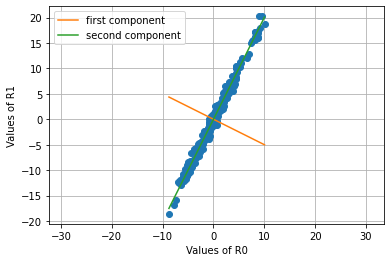

In [17]:
# Plot de-meaned x - y correlation
plt.plot(R[0,:],R[1,:],'o')

# Plot the first principal component
plt.plot(xx,yy1,label='first component')

# Plot the second principal component
plt.plot(xx,yy2,label='second component')

plt.legend()

plt.xlabel('Values of R0')

plt.ylabel('Values of R1')

plt.grid()

plt.axis('equal');

The higher expanatory value of component2 is reflected in the eigenvalues: 



In [18]:
print(EIG[0])

[ 0.18152713 84.46199612]


## Example 1: Vol-Curve Modelling

A very common use case for PCA is the modelling of yield curves for bonds or implied volatility curves for options. Here, we look at implied volatility (IV). 
The IV of an option tells you whether the option is relatively cheap or expensive. The X-axis is expressed in deltas, which is a way to normalize the strike prices of options. An ATM or at-the-money option (where the strike is closest to the price of the underlying stock) usually has a delta close to 0.5 while ITM, or in-the-money options have deltas>0.5 and OTM (out-of-the-money) options have deltas less than 0.5 .

In our example here we use the vol-curves for OTM put options.

Let's first upload some vol-curve data:

In [19]:
# Upload 'vol_curves.pick' and un-pickle it.
uploaded = files.upload()

Saving vol_curves.pick to vol_curves.pick


In [20]:
vol_curves = pickle.load(open('vol_curves.pick','rb'))

Text(0, 0.5, 'implied volatility')

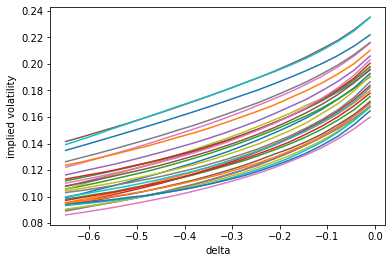

In [21]:
delta = np.linspace(-0.65,-0.01,20)
for curve in vol_curves:
  plt.plot(delta,curve)

plt.xlabel('delta')
plt.ylabel('implied volatility')

Next, we perform the PCA and plot the most significant principle components. The cumulative sum of them is also called the "explained variance". We can see that out of the 30 components, the 4 most significant once can explain almost 100% of the variance.

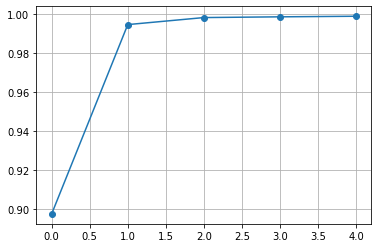

In [22]:
eig = np.linalg.eig(np.cov((vol_curves-np.mean(vol_curves,axis=0))))

plt.plot(np.cumsum(np.real((np.sort(eig[0])[-5:])[::-1]/sum(eig[0]))),'-o')
plt.grid()

In some cases, such as in curve modelling, principal components actually have a meaning. The first three components in vol-curves denote the level, slope and curvature of the curves. With that, we would be able to reconstruct our vol-curves quite accurately. For the sake of demonstration and simplicity we only demonstrate a very crude approximation here. 

Let's have a look how we can do this:

### Level of the Vol Curve

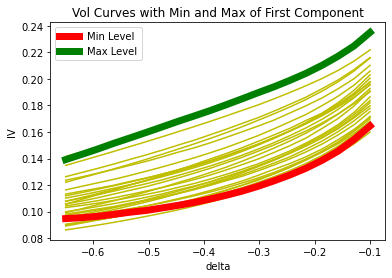

In [23]:
X = np.linspace(-0.65,-0.1,20)
for n in vol_curves:
  plt.plot(X,n,'y')
max_level = np.argmax(np.real(eig[1])[:,0])
min_level = np.argmin(np.real(eig[1])[:,0])
plt.plot(X,vol_curves[max_level],'r-',lw=7,label='Min Level')
plt.plot(X,vol_curves[min_level],'g-',lw=7,label='Max Level')
plt.xlabel('delta')
plt.ylabel('IV')
plt.title('Vol Curves with Min and Max of First Component')
plt.legend()

### Curvature of the Vol Curve

curvature: 0.007886463858959025
curvature: 0.0067534898690382456
curvature: 0.006744818036329023
curvature: 0.008132509951451011
curvature: 0.008744329681090637
curvature: 0.007648235964239067
curvature: 0.0070913399157014195
curvature: 0.00690018481196282
curvature: 0.007782693084117498
curvature: 0.009489105587569088
curvature: 0.009561085028184396
curvature: 0.00783978819383055
curvature: 0.008007345541393665
curvature: 0.007331953769233485
curvature: 0.006319386105640298
curvature: 0.006020794805663782
curvature: 0.006558010927987856
curvature: 0.005913353970232682
curvature: 0.0051524968391334774
curvature: 0.0062482923776809585
curvature: 0.004962718579029135
curvature: 0.007529818083328796
curvature: 0.007718209594251874
curvature: 0.008964219707787907
curvature: 0.007899899532307186
curvature: 0.007666420160095
curvature: 0.00925788675443448
curvature: 0.010192498467904695
curvature: 0.009539427354401109
curvature: 0.00863161360114846
Max curvature: 0.00925788675443448


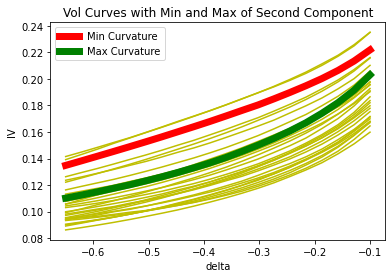

In [44]:
X = np.linspace(-0.65,-0.1,20)
for n in vol_curves:
  plt.plot(X,n,'y')
  print('curvature:',sum(np.diff(n,2)))
max_level = np.argmax(np.real(eig[1])[:,1])
min_level = np.argmin(np.real(eig[1])[:,1])
plt.plot(X,vol_curves[max_level],'r-',lw=7,label='Min Curvature')
plt.plot(X,vol_curves[min_level],'g-',lw=7,label='Max Curvature')
plt.xlabel('delta')
plt.ylabel('IV')
plt.title('Vol Curves with Min and Max of Second Component')
plt.legend()
print('Max curvature:',sum(np.diff(vol_curves[min_level],2)))

### Tilt of the Vol Curve

tilt: 0.09356460691508237
tilt: 0.08438601164857384
tilt: 0.08457507697054834
tilt: 0.08967622399256955
tilt: 0.08174408695818951
tilt: 0.07740195686434292
tilt: 0.07368297984119891
tilt: 0.07887439503616842
tilt: 0.0765572789787289
tilt: 0.07469481116228247
tilt: 0.06982295398466591
tilt: 0.07492566756796991
tilt: 0.07727690727294456
tilt: 0.08075987723826514
tilt: 0.0877703204190507
tilt: 0.09368547502865793
tilt: 0.09359317319103119
tilt: 0.08982263782484295
tilt: 0.09168578559899646
tilt: 0.09587955891665123
tilt: 0.08705921177408801
tilt: 0.08659340941433559
tilt: 0.08600911548257575
tilt: 0.08731938473892188
tilt: 0.08956043296714612
tilt: 0.08787943810321924
tilt: 0.09288369240163902
tilt: 0.08348055194664973
tilt: 0.08676232845244691
tilt: 0.0821600704933817
Max tilt: 0.09587955891665123


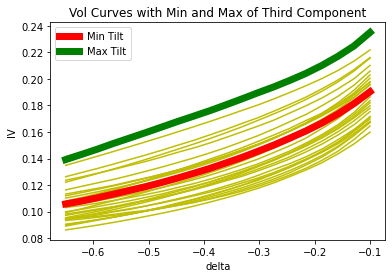

In [25]:
X = np.linspace(-0.65,-0.1,20)
for n in vol_curves:
  plt.plot(X,n,'y')
  print('tilt:',sum(np.diff(n,1)))
max_level = np.argmax(np.real(eig[1])[:,2])
min_level = np.argmin(np.real(eig[1])[:,2])
plt.plot(X,vol_curves[max_level],'r-',lw=7,label='Min Tilt')
plt.plot(X,vol_curves[min_level],'g-',lw=7,label='Max Tilt')
plt.xlabel('delta')
plt.ylabel('IV')
plt.title('Vol Curves with Min and Max of Third Component')
plt.legend()
print('Max tilt:',sum(np.diff(vol_curves[min_level],1)))

Here we go, we just built a three component model for vol-curves. More advanced versions of this are often used in vol-curve arbitrage trades.

## Exanple 2: Building A Stock Index

This is not particularly exciting but it gets really interesting when we use a range of instruments and build an index. Let's build a FAANG index. First, we download the data.

In [26]:
data = yf.download("FB AMZN AAPL NFLX GOOGL MSFT", start="2012-06-01", end="2021-05-30")

[*********************100%***********************]  6 of 6 completed


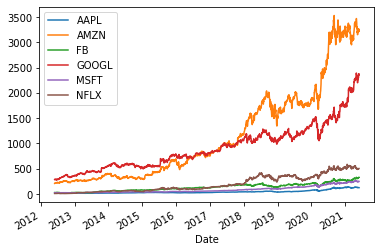

In [27]:
data['Adj Close'].plot()

In [28]:
data

Adj Close                           ...   Volume                    
                  AAPL         AMZN          FB  ...    GOOGL      MSFT      NFLX
Date                                             ...                             
2012-06-01   17.202688   208.220001   27.719999  ...  6109684  56634300  35578200
2012-06-04   17.303879   214.570007   26.900000  ...  4860535  47926300  35291200
2012-06-05   17.259109   213.210007   25.870001  ...  4675120  45715400  24048500
2012-06-06   17.523745   217.639999   26.809999  ...  4187408  46860500  30676800
2012-06-07   17.531717   218.800003   26.309999  ...  3513483  37792800  21045500
...                ...          ...         ...  ...      ...       ...       ...
2021-05-24  126.909851  3244.989990  324.630005  ...  1591600  21411500   2412600
2021-05-25  126.710159  3259.050049  327.790009  ...  1122000  17704300   2699500
2021-05-26  126.660225  3265.159912  327.660004  ...  1078600  17771600   2465300
2021-05-27  125.092575  3230.110107  332.750000  ...  1761200  24426200   3253800
2021-05-28  124.423584  3223.070068  328.730011  ...  1074100  18270200   2910300

[2263 rows x 36 columns]

#### First, plot the normalized dataset

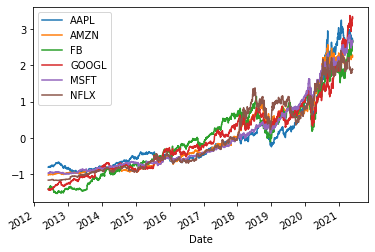

In [29]:
normalized = (data['Adj Close']-data['Adj Close'].mean())/data['Adj Close'].std()
normalized.plot()

#### Running PCA with the Sklearn PCA function

Luckily, we don't need to build our own PCA function as Sklear can do this for us very easily.

The first principal component is the linear combination of the input data that explains most of the variance

In [30]:
pca = PCA(1).fit(data['Adj Close'].values.T)

#### Generate the index from the principal components

In [31]:
index=pca.components_[0].T

#### Plot the index of the FAANG stocks

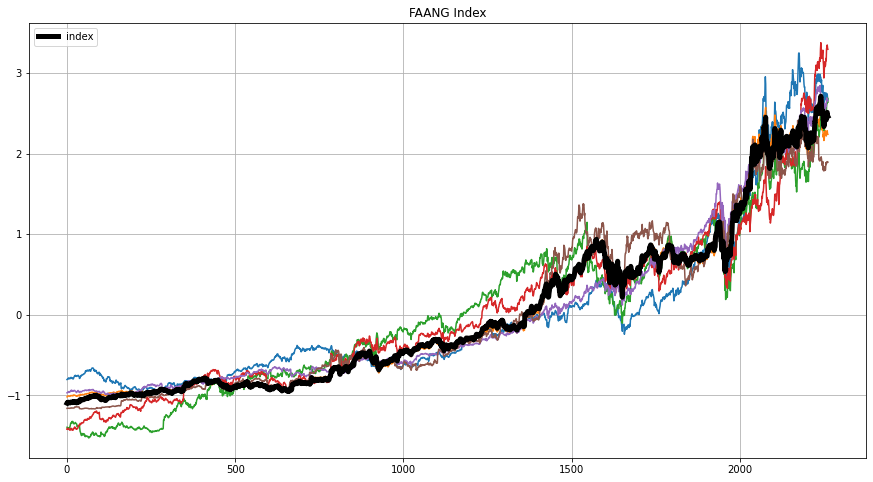

In [32]:

plt.figure(figsize=[15,8])
plt.plot(normalized.values)
plt.plot((index-np.mean(index))/np.std(index),'k',lw=5,label='index')
plt.legend()
plt.title('FAANG Index')
plt.grid();


## Cointegration

### Short recap: cointegration versus correlation

- Cointegrated price series do not necessarily have to be correlated and vice-versa 

- Drunk and her dog: https://www.researchgate.net/publication/254330798_A_Drunk_and_Her_Dog_An_Illustration_of_Cointegration_and_Error_Correction

- Same behaviour in the markets and causality relationships change. For more information please refer to Engle-Granger causality (https://www.google.com/url?sa=t&rct=j&q=&esrc=s&source=web&cd=1&cad=rja&uact=8&ved=2ahUKEwjcvKPcsqDeAhXTbCsKHTmNAe8QFjAAegQIBxAB&url=https%3A%2F%2Fen.wikipedia.org%2Fwiki%2FGranger_causality&usg=AOvVaw1mYq3HhcjsVNJ9zJ6zgqdV)


Engel-Granger Causality

#### Simulating Cointegration

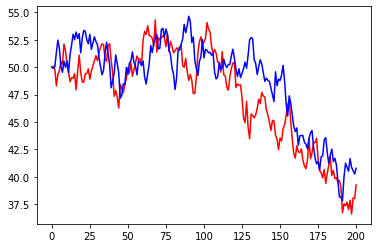

In [33]:
def make_coint_0(N,T0=[0,0],sigma=[1,1],c=[0.1,0.1]):
    '''
    Algorithm from:
    https://www.researchgate.net/publication/254330798_A_Drunk_and_Her_Dog_An_Illustration_of_Cointegration_and_Error_Correction
    '''
    X = [0]
    Y = [0]
    for i in range(N):
        rx = np.random.randn()*sigma[0] - c[0]*(X[-1] - Y[-1])
        ry = np.random.randn()*sigma[1] + c[1]*(X[-1] - Y[-1])
        X.append(X[-1]+rx)
        Y.append(Y[-1]+ry)
    return np.array(X)+T0[0],np.array(Y)+T0[1]

X,Y = make_coint_0(200,T0=[50,50],c=[0.1,0.1])
plt.plot(X,'r-',Y,'b-');

#### Cointegration Test

coint uses the augmented Engle-Granger two-step cointegration test.

In [34]:
coint(X,Y)

(-4.443281213143872,
 0.0015155246762492956,
 array([-3.95203768, -3.36685108, -3.065724  ]))

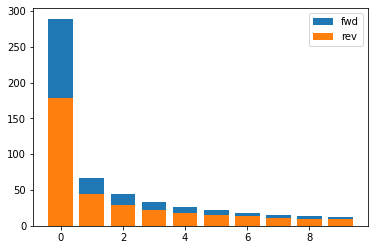

In [35]:
X,Y = make_coint_0(200,T0=[50,50],c=[0.8,0.6])

lags = 10

# Calculating the EG-Test in one direction
result = grangercausalitytests(np.array([X,Y]).T, lags, verbose=False)

# Extracting results
res_fwd = [(list(result.values())[lag][0]['ssr_ftest'][0]) for lag in range(lags)]

# Calculating the EG-Test in reverse direction
result = grangercausalitytests(np.array([Y,X]).T, lags, verbose=False)

# Extracting results
res_rev = [(list(result.values())[lag][0]['ssr_ftest'][0]) for lag in range(lags)]

plt.bar(range(lags),res_fwd,label='fwd')
plt.bar(range(lags),res_rev,label='rev')
plt.legend()

#### Cointegration of FAANG stocks

In [36]:
coints = []
for i in range(data['Adj Close'].values.shape[1]):
    for k in range(i,data['Adj Close'].values.shape[1]):
        if not i==k:
            coints.append(coint(data['Adj Close'].values.T[i],data['Adj Close'].values.T[k])[0])

            print(i,k,coints[-1])

0 1 -1.6579600789225617
0 2 -1.7378324989436493
0 3 -2.4133119475825566
0 4 -2.6838647778951903
0 5 -1.5691272777882137
1 2 -2.1494465310175563
1 3 -2.329260820078386
1 4 -2.364688089755218
1 5 -3.214677877165737
2 3 -2.883520392347682
2 4 -2.1329258008544874
2 5 -2.3648197400413005
3 4 -1.6982279997628797
3 5 -1.7143920373815462
4 5 -1.3172382389890134


## Example 3: Statistical Arbitrage

First, we define some functions for PCA and Z-score.

In [37]:
def get_resids(d):
  pca = PCA(1).fit(d.T)
  index=pca.components_[0]
  mm = [sm.OLS(s, index).fit() for s in d.T]
  return list(map(lambda x: x.resid, mm))

def Zscore(X):
    return np.array((X - np.mean(X)) / np.std(X))

#### Next, we download some data from Yahoo Finance.

In [38]:
data2 = yf.download("AAPL NFLX", start="2019-01-01", end="2021-05-30")

[*********************100%***********************]  2 of 2 completed


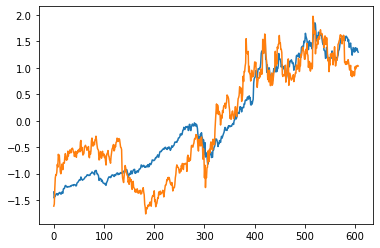

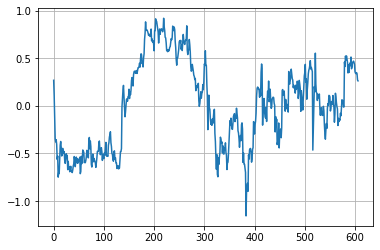

In [39]:
aapl = data2['Adj Close']['AAPL']
nflx = data2['Adj Close']['NFLX']
plt.plot(Zscore(aapl))
plt.plot(Zscore(nflx))

plt.show()

plt.plot(Zscore(aapl)-Zscore(nflx))
plt.grid()

#### A simple pairs trading backtest

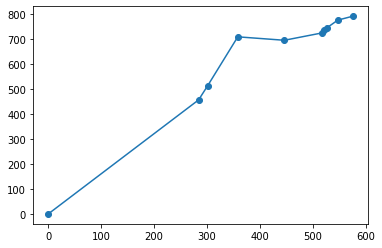

In [40]:
def backtest(aapl,nflx,th):
  inpos = 0
  lkbk = 200
  pnls = [0]
  idxs = [0]

  for i in range(len(aapl)):
    # GET DATA FROM MARKET
    if i<lkbk:
      continue

    za = Zscore(aapl[i-lkbk:i])
    zn = Zscore(nflx[i-lkbk:i])

    signal = za[-1] - zn[-1]
    if not inpos:
      pca = PCA(1).fit(np.array([aapl[i-lkbk:i],nflx[i-lkbk:i]]).T)
      hedge_ratio = pca.components_[0,1]/pca.components_[0,0]
      
    
    if inpos==0 and signal<-th:
      entry = aapl[i]*hedge_ratio - nflx[i] 
      # SEND ENTRY ORDERS TO MARKET
      inpos = 1

    elif inpos>0 and signal>0:
      pnl =  (aapl[i]*hedge_ratio - nflx[i]) - entry
      inpos = 0
      pnls.append(pnl)
      idxs.append(i)

    if inpos==0 and signal>th:
      entry =  aapl[i]*hedge_ratio - nflx[i]
      inpos = -1

    elif inpos<0 and signal<0:
      pnl = entry - (aapl[i]*hedge_ratio - nflx[i])
      inpos = 0
      pnls.append(pnl)
      idxs.append(i)

  return idxs,pnls

idxs,pnls = backtest(aapl,nflx,0.6)
plt.plot(idxs,np.cumsum(pnls),'-o');

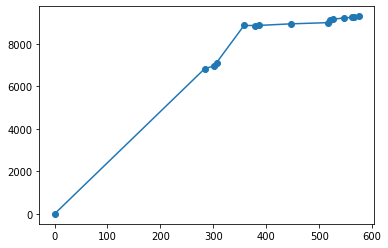

In [41]:
ths = np.linspace(0.4,2.6,15)
ts = []
for th in ths:
  idxs,pnls = backtest(aapl,nflx,th)
  ts.append(pd.Series(pnls,index=idxs))

df = pd.DataFrame(ts).T.fillna(0)

plt.plot(df.cumsum().sum(axis=1),'-o')

## Example 4: Portfolio Statarb

Here we apply statistical arbitrage to a portfolio. I some sense, this is a generalization of pairs trading. We rank the stocks with PCA and create a long/short portfolio with N long and N short stocks, where N is set by "max_pos". Make sure N is less then half the number of stocks in your universe.

In [42]:
pr = np.array(data['Adj Close']).T
max_pos=1
initial_cash=1e6

entry = {} # create a vector of entry prices
pnls = [] # create a pnl vector

# Exit if we specified too large long/short position size
if max_pos > pr.shape[0]/2:
    print('max_pos too large!')
    adfadsf

# loop through the prices
for i,pri in enumerate(pr.T):

    # Make sure you have enough data points for PCA
    if i < 50: continue

    # Run the PCA, only on the past prices
    resids = get_resids(pr.T[max([0,i-60]):i])
    zs = {}

    # Cal#culate the z-scores for each instrument. 
    for inst in range(len(pri)):
        try: zs[inst] = Zscore(resids[inst])[-1]
        except: 
          print(traceback.format_exc())

    pnl = 0
    # Calculate the Pnl for each position over the prevoius period
    for j,idx in enumerate(entry):

        # Calculate the position size
        # The sign of the position depends on the sign of the entry price
        pos = np.round((initial_cash/len(pri))/entry[idx])

        # Add up the pnls for all positions for the last period
        # We neutralize the sign of the entry price and let it 
        # come in through the position.
        pnl += (pri[idx]-np.abs(entry[idx]))*pos
        
    pnls.append(pnl)

    # Reset the portfolio
    entry = {}

    # Find the new instruments to be traded based on their z-scores
    idx_long = (np.argsort([zs[j] for j in zs])[:max_pos])
    idx_short = (np.argsort([zs[j] for j in zs])[-max_pos:])

    # Add them to the entry list
    # The entry gets a positive or negative sign depending on the side of the trade
    for idx in idx_long:
        entry[idx] = pri[idx]
    for idx in idx_short:
        entry[idx] = -pri[idx]

    #print(i,sum(pnls))

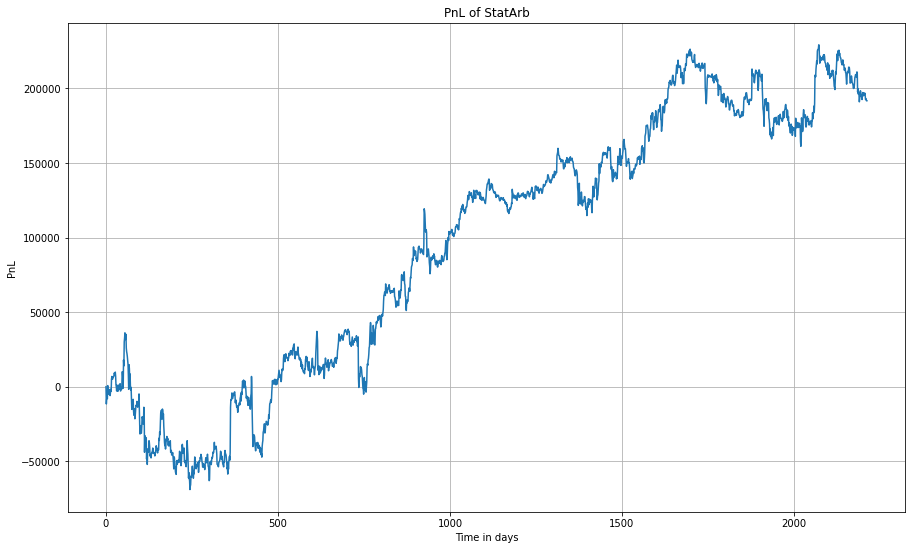

In [43]:
plt.figure(figsize=[15,9])
plt.plot(np.cumsum(pnls))
plt.title('PnL of StatArb')
plt.xlabel('Time in days')
plt.ylabel('PnL')
plt.grid()